---
layout: single
title: "보간법(interpolation)"
categories: machine_learning
tags: [applied_mathematics, interpolation]
use_math: true
publish: false
author_profile: false
toc: true
---

interpolation(보간법)에 대하여 한 번 정리해봤습니다.
정확하게는, 어떤 정형데이터가 주어졌을 때 그 데이터의 특정 컬럼에 결측치가 발생했을 경우에 그 결측치를 처리하는 방법에 대해 고민해보았습니다.
아주 기본적인 interpolation에 대해서만 이야기해보았고, 세부적인 사항은 많이 생략하게 될 것 같습니다.

(`ipnyb`로 포스트를 작성할 때에 그림 파일이 제대로 잘 변환되지 않는 오류를 아직 해결하고 있지 못하고 있습니다.
그래서 아직 genetic algorithm 포스트도 미완인 상태로 있습니다.)

# 1 univariate interpolations

univariate interpolation이라는 말에서 변수가 한 개(univariate)라는 의미는 독립변수($x$)의 개수가 한 개라는 것입니다.
vector valued function을 다루지는 않으니 독립변수($y$)도 하나라고 하면, 실제로는 두 개의 변수를 다루게 됩니다.

여기에서 하려고 하는 것은, $n+1$개의 data sample $(x_i,y_i)$들이 주어져 있을 때 ($i=0,1,2,\cdots n$, $x_0\lt x_1\lt\cdots\lt x_n$), 모든 $i$에 대하여 $f(x_i)=y_i$를 만족시키는 함수 $f:\mathbb R\to\mathbb R$을 찾는 것입니다.
$y$좌표가 결측된 어떤 data sample $(x',?)$이 주어져있을 때, 이 결측치를 $f$를 통해 보간하여 $(x',f(x'))$로 만드는 것이 목적입니다.

<!-- <div class="notice--danger">
그러니까 $\sum_i||f(x_i)-y_i||^2$의 값을 최소로 하는 $f$를 찾아야 하는 일반적인 regression 문제와는 조금의 차이가 있겠습니다. -->

<!-- 또한, 각각의 $x_i$들이 다 달라야(distinct) 위의 문제가 성립할 수 있을 것입니다. -->
<!-- 또한, $x_i=x_j$, $y_i\ne y_j$를 만족시키는 서로 다른 $i$, $j$가 존재하는 경우에는 위의 문제가 성립할 수 없을 것입니다. -->
<!-- (regression 문제를 풀 때에는 그것이 문제가 되지 않았었습니다.)
이 경우에는 위의 $f(x_i)=y_i$ 조건 대신
$$f(x_i)=\frac1{|\{j:x_j=x_i\}|}\sum_{j:x_j=x_i}y_j$$
의 조건을 사용할 수도 있을 것 같습니다. -->
<!-- </div> -->

보간의 결과로 나타나는 함수 $f$를 interpolant라고도 부릅니다.
이 문제상황을 그림으로 그려보면 다음과 같습니다.
$n+1$개의 점이 이미 찍혀있는 상태에서, 이 점들을 적절히 이어서 새로운 함수 $f$를 만드는 것입니다.

![]({{site.url}}\images\2023-05-27-interpolation\1a.gif){: .img-50-center}

$n+1$개의 점 $(x_i,y_i)$를 찍는 코드는 다음과 같습니다.

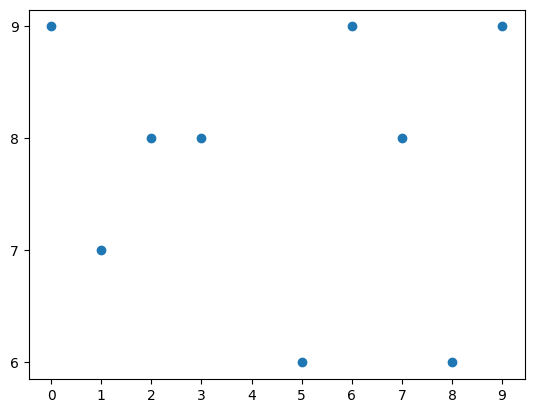

In [8]:
# generating an arbitrary sequence of numbers with (possibly) missing values
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
min = 5
max = 10
length = 10
x = np.arange(0, length)
y = np.random.randint(min, max, length)
x = np.delete(x, np.where(y == 5))
y = np.delete(y, np.where(y == 5))
plt.xticks(np.arange(0, length, 1))
plt.yticks(np.arange(min ,max, 1))
plt.scatter(x,y)
plt.savefig("../../images/2023-05-27-interpolation/1c.png")

## 1.1 vanilla interpolations

다음 방법들은 너무나도 간단한, 그래서 사실 그렇게 큰 의미는 없는 interpolation 방식입니다.

### 1.1.1 nearest neighbor

함수 $f:[x_0,x_n]\to\mathbb R$을 다음과 같이 정의합니다.
말 그대로, 주어진 $x$에 대하여 $x$에서 가장 가까이 있는 $x$좌표가 $x_i$이면 $y_i$에 그 함숫값을 대응시키는 것입니다.

$$
f(x)=
\begin{cases}
y_0&(x_0\le x\lt\frac{x_0+x_1}2)\\[5pt]
y_1&(\frac{x_0+x_1}2\le x\lt\frac{x_1+x_2}2)\\[5pt]
y_2&(\frac{x_1+x_2}2\le x\lt\frac{x_2+x_3}2)\\[5pt]
&\vdots\\[5pt]
y_{n-1}&(\frac{x_{n-2}+x_{n-1}}2\le x\lt\frac{x_{n-1}+x_n}2)\\[5pt]
y_n&(\frac{x_{n-1}+x_n}2\le x\le x_n)
\end{cases}
$$

이 정의에서 (그리고 아래의 두 정의에서) $\le$와 $\lt$는 큰 의미가 있지 않습니다.
이것들을 반대로 바꾸면, 엄밀하게는 이전과는 다른 함수가 될테지만, (특히 프로그래밍적으로는) 그 차이는 큰 의미가 없을 것입니다.

univariate interpolation을 파이썬 코드로 구현할 때 `scipy.interpolate.interp1d` 메소드를 이용할 수 있습니다.

In [22]:
# interpolation function
from scipy import interpolate
def interp(kind, filename):
    f = interpolate.interp1d(x, y, kind=kind)
    xnew = np.arange(0, length-1, 0.1)
    ynew = f(xnew)
    plt.plot(x, y, 'o', xnew, ynew, '-')
    plt.xticks(np.arange(0, length))
    plt.yticks(np.arange(6, 10))
    plt.savefig("../../images/2023-05-27-interpolation/"+filename+".png")


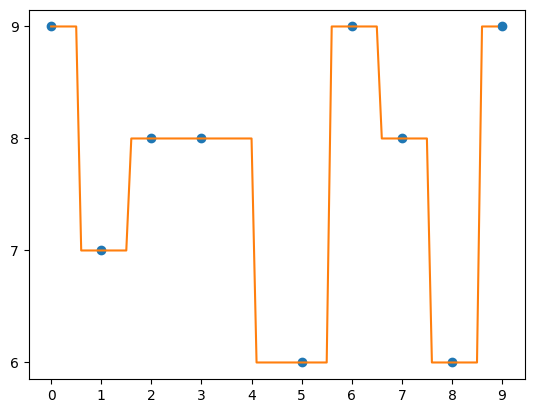

In [23]:
# 1.1.1 nearest
# ‘nearest-up’ and ‘nearest’ differ when interpolating half-integers (e.g. 0.5, 1.5) in that ‘nearest-up’ rounds up and ‘nearest’ rounds down.
interp('nearest', "1.1.1a")

### 1.1.2 previous

이번에는 각 구간 $[x_{i-1}, x_i]$에 대한 함숫값을 $y_{i-1}$로 대응시키는 것입니다.
식으로 쓰면 다음과 같습니다.

$$
f(x)=
\begin{cases}
y_0&(x_0\le x\lt x_1)\\[5pt]
y_1&(x_1\le x\lt x_2)\\[5pt]
y_2&(x_2\le x\lt x_3)\\[5pt]
&\vdots\\[5pt]
y_{n-2}&(x_{n-2}\le x\lt x_{n-1})\\[5pt]
y_{n-1}&(x_{n-1}\le x\le x_n)\\[5pt]
\end{cases}
$$

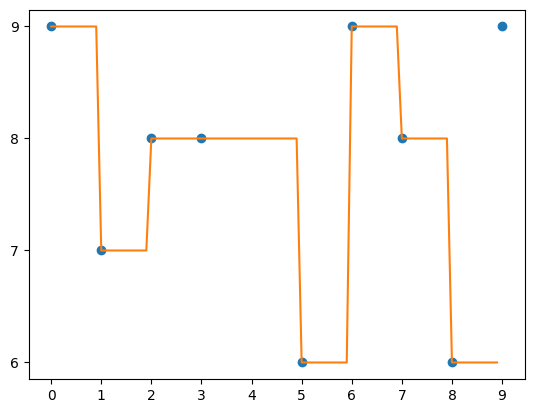

In [24]:
# 1.1.2 previous
# ‘previous’ simply return the previous value of the point;
interp('previous', "1.1.2a")

넓은 의미에서 이것을 (뒤에 나올) spline interpolation에 포함시킬 수 있습니다.
즉, 각 구간 $[x_{i-1},x_i]$의 함수 $f_i$를 0차함수(=상수함수)로서 모델링하는 것입니다.
그런 의미에서 `scipy.interpolate.interp1d`의 `kind` 옵션을 `'zero'`로 두어 얻어낼 수도 있습니다.

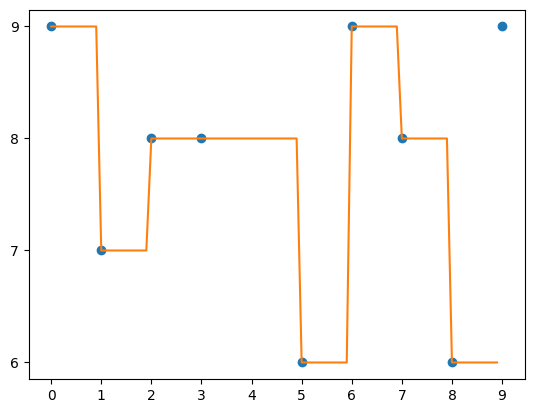

In [27]:
# ‘zero’ refer to a spline interpolation of zeroth order;
interp('zero', "1.1.2b")

### 1.1.3 next

`previous`의 반대입니다.

$$
f(x)=
\begin{cases}
y_1&(x_0\le x\lt x_1)\\[5pt]
y_2&(x_1\le x\lt x_2)\\[5pt]
y_3&(x_2\le x\lt x_3)\\[5pt]
&\vdots\\[5pt]
y_{n-1}&(x_{n-2}\le x\lt x_{n-1})\\[5pt]
y_n&(x_{n-1}\le x\le x_n)\\[5pt]
\end{cases}
$$

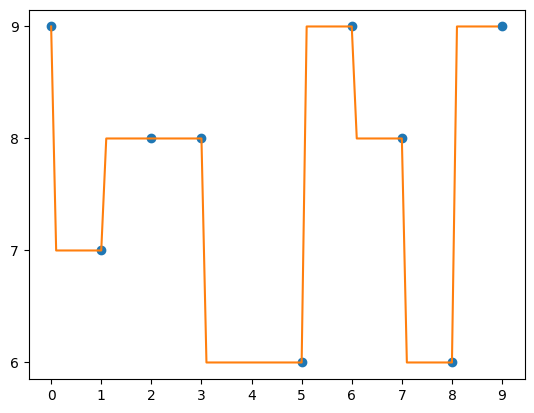

In [29]:
# 1.1.3 next
# ‘next’ simply return the next value of the point;
interp('next', "1.1.3a")

# 1.2 polynomial interpolation

$n+1$개의 점이 찍혀있을 때, 이 $n+1$개의 점을 지나는 $n$차 다항식을 항상 찾을 수 있습니다.
이것을 interpolation theorem이라고 하는데, wikipedia의 statement를 그대로 따라 적어보면 다음과 같습니다.

> There exists a unique polynomial of degree at most $n$ that interpolates the $n+1$ data points $(x_0,y_0),(x_1,y_1),\cdots,(x_n,y_n)
\in\mathbb R^2$, where no two $x_j$ are the same.

이 정리는, 보통 중학교 수학에서 많이 하듯이, 좌표평면 위에 세 점이 있다면 그 세 점을 잇는 포물선이 유일하게 결정된다는 사실을 놓고 보면 정말 당연한 말처럼 들립니다. (다만, 세 점이 한 직선위에 있다면 포물선이 아닌 직선이 유일하게 하나 결정됩니다.)
하지만 그 증명이 아주 쉽지는 않습니다.
wikipedia에 소개된 증명을 간단하게만 보면, Lagrange basis function이나 Vandermonde matrix 같은 미묘한 수학적인 개념들을 사용하는 것 같습니다.
증명은 생략하기로 하고, 이 polynomial interpolation에 대해 조금 더 써보겠습니다.

polynomial interpolation을 사용하면, $n+1$개의 점을 지나는 다항식을 정말로 만들 수 있습니다.
문제는 이러한 접근방법이 그렇게 좋지는 않다는 것입니다.
고차다항식은 그 그래프가 상상이상으로 복잡합니다.
우리가 원하는 것은 $n+1$개의 점들을 잇는 '적당한' 함수를 찾는 것인데, 그 결과 함수(interpolant)가 너무 복잡하다면 적절하지 않습니다.
일종의 overfitting이 발생하는 셈입니다.

그래서, 이러한 polynomial interpolation 방법은 일반적으로 잘 쓰이지 않고, 다음과 같은 spline interpolation을 많이 사용하게 됩니다.
polynomial interpolation이 고차원의 다항함수 한 개를 사용하여 $n+1$개의 점을 모두 지나도록 의도한 것이라면, spline interpolation에서는 저차원의 다항함수 여러 개($n$개)를 사용하는 것이라고 말할 수 있습니다.

## 1.3 spline interpolation

총 $n+1$개의 점들에 대하여, $n$개의 구간 $[x_{i-1},x_i]$을 생각할 수 있습니다($i=1,2,\cdots,n$).
이 구간의 양 끝점 $(x_{i-1},y_{i-1})$, $(x_i,y_i)$을 지나는 저차원의 다항함수 $f_i$를 만들어내는 것이 spline interpolation의 방법입니다.

<!-- 이번에는 다항함수를 사용해 $f_i$를 만들어봅니다.
즉, 보간을 위해 일종의 모델링을 하는 것인데, 어려운 모델링이 아니기 때문에 그 결과는 deterministic하게 나타납니다. -->

### 1.3.1 linear (spline) interpolation

1차함수를 통해 $f_i$를 만들어냅니다.

가장 간단하게 생각해볼 수 있는 polynomial interpolation입니다.
`scipy.interpolate.interp1d`의 `kind` 파라미터의 default 옵션(`linear`)이기도 합니다.

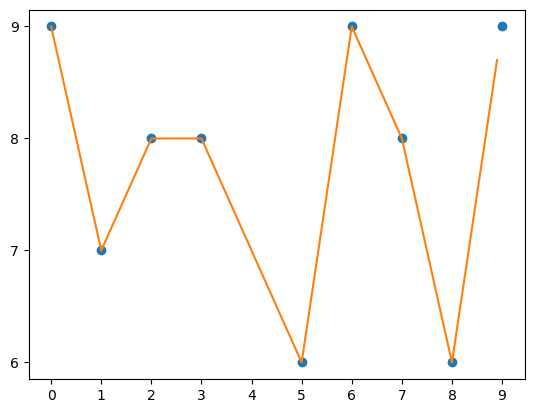

In [38]:
# 1.3.1 linear : first order
# the default interpolation
interp('linear', "1.3.1a")

`slinear` 옵션은 `linear` 옵션과 거의 같은 것으로 생각됩니다.
[이곳](https://stackoverflow.com/questions/17572390/in-scipy-what-is-slinear-interpolation)과 [이곳](https://gist.github.com/stringfellow/8ae4d3f25ca525e75bb79c01fbda4a24)에 그 차이가 설명되어 있다고 하는데, 자세히 읽어보지는 않았습니다.

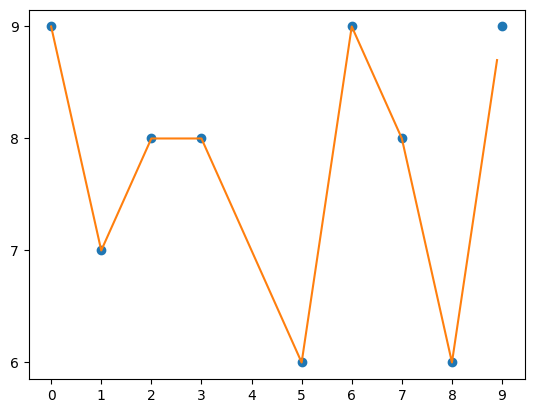

In [36]:
# ‘slinear’ refers to a spline interpolation of first order
interp('slinear', "1.3.1b")

거창하게 linear interpolation이라고 되어 있지만, 단순히 knot들을 선분으로 이은 것에 불과합니다.
그래도 식으로 굳이 한 번 써보면

$$
f(x)=
\begin{cases}
\frac{y_1-y_0}{x_1-x_0}(x-x_0)+y_0&(x_0\le x\lt x_1)\\[5pt]
\frac{y_2-y_1}{x_2-x_1}(x-x_1)+y_1&(x_1\le x\lt x_2)\\[5pt]
\frac{y_3-y_2}{x_3-x_2}(x-x_2)+y_2&(x_2\le x\lt x_3)\\[5pt]
&\vdots\\[5pt]
\frac{y_{n-1}-y_{n-2}}{x_{n-1}-x_{n-2}}(x-x_{n-1})+y_{n-1}&(x_{n-2}\le x\lt x_{n-1})\\[5pt]
\frac{y_n-y_{n-1}}{x_n-x_{n-1}}(x-x_{n-1})+y_{n-1}&(x_{n-1}\le x\lt x_n)
\end{cases}
$$

와 같이 될 것입니다.

1.3.2, 1.3.3에서의 논의를 위해 위의 문제를 다음과 같이 풀어보겠습니다.
구간 $[x_{i-1},x_i]$에서 함수 $f_i$를 $f_i(x)=a_ix+b_i$라고 하면 ($i=1,2,\cdots,n$), 총 $2n$개의 unknown parameter들을 결정해야 합니다.
그런데, 이 $f_i$들은 각각 $f(x_{i-1})=y_{i-1}$, $f(x_i)=y_i$을 만족해야 하므로, 총 $2n$개의 조건(constraint)을 가지고 있습니다.
$2n$개의 unkown들을 $2n$개의 constraint들로 풀어낼 수 있으므로 이 문제는 잘 풀리는 문제입니다.

$$
\begin{align*}
\text{\# of unknowns }&:{ 2n}\\
\text{\# of constraints }&:{ 2n}
\end{align*}
$$

이 함수 $f$는 연속함수이지만, 미분가능하지는 않습니다.
(그리고, 당연히, 도함수가 연속이지 않습니다.)
다시 말해,

$$f\in C[x_0,x_n]$$

이 성립합니다. ($f$가 연속함수라는 뜻입니다.)

### 1.3.2 quadratic spline interpolation

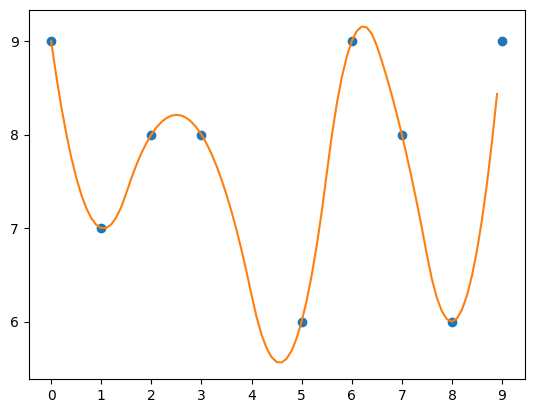

In [35]:
# 1.3.2 quadratic : second order
interp('quadratic', "1.3.2a")

2차함수를 통해 $f_i$를 만들어냅니다.
즉, knot들을 포물선으로 연결하게 되는데, 두 점을 잇는 포물선은 유일하지 않습니다.
따라서 추가적인 조건을 더 부여합니다.
각 knot에서의 미분계수가 같도록, 그러니까 미분가능해지도록 합니다.

구간 $[x_{i-1},x_i]$에서 함수 $f_i$를

$$f_i(x)=a_ix^2+b_ix+c_i\qquad (i=1,2,\cdots,n)$$

라고 하면, 총 $3n$개의 unknown parameter들을 결정해야 합니다.
한편, 각 포물선들이 양 끝점을 지나야 한다는 조건

$$f_i(x_{i-1})=y_{i-1},\quad f_i(x_i)=y_i,\qquad (i=1,2,\cdots,n)$$

으로부터 $2n$개의 constraint들을 얻어낼 수 있습니다.
여기에 미분가능 조건

$${f_{i-1}}'(x_i)={f_i}'(x_i),\qquad (i=2,3,\cdots,n)$$

으로부터 $n-1$개의 추가적인 constraint들을 얻어낼 수 있습니다.

$$
\begin{align*}
\text{\# of unknowns }&:{ 3n}\\
\text{\# of constraints }&:{ 3n-1}
\end{align*}
$$

이것 외에 더 추가해야 하는 constraint는 없습니다.
따라서 1의 degree of freedom이 생기는 셈입니다.
추가적으로 어떤 constraint을 더 넣을 지는 꽤 임의적으로 결정할 수 있는 듯합니다.
[여기](https://psu.pb.unizin.org/polynomialinterpretation/chapter/chapter-three-quadratic-spline-interpolation/)에서는 $a_0=0$으로 두는 constraint를 추가하고 있습니다.

이 함수 $f$는 미분가능하고, 그 도함수가 연속이기까지 합니다.
다시 말해,

$$f\in C^1[x_0,x_n]$$

이 성립합니다. ($f$의 도함수까지 연속이라는 뜻입니다.)

### 1.3.3 cubic spline interpolation

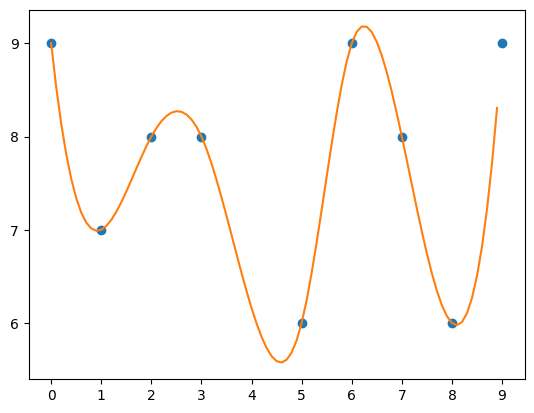

In [40]:
# 1.3.3 cubic : third order
# popular interpolation
interp('cubic', "1.3.3a")

3차함수를 통해 $f_i$를 만들어냅니다.
quadratic spline보다 더 많은 조건을 부여합니다.
각 knot에서의 이계미분계수가 같도록, 그러니까 이계미분가능(twice-differentiable)해지도록 합니다.

가장 흔히 쓰이는 방식의 spline interpolation입니다.
quadratic spline에서는 이계미분가능성까지도 보장하기때문에, 그래프의 곡률이 급격하게 바뀌지 않습니다.
왜냐하면, 함수 $y=f(x)$의 $x=a$에서의 곡률 $\kappa$가

$$\kappa = \frac{f''(a)}{(1+\{f'(a)\}^2)^{\frac32}}$$

와 같이 나타나기 때문입니다.

만약, 보간해야 할 column이 물리적인 의미를 가지고 있다면, cubic spline이 가지는 의미는 더 커집니다.
예를 들어, 어떤 물체의 위치 (특정한 방향으로의 좌표)를 나타내는 column을 보간한다고 하면, $f'(x)$는 그 방향으로의 속도성분을, $f''(x)$는 가속도를 의미할 것입니다.
실제 현실에서 속도가 불연속적으로 변하거나, 가속도가 (그러니까 작용하는 힘이) 불연속적으로 변하는 일은 없으므로, cubic spline interpolation을 사용하면, 주어진 (물리적인) 데이터가 속도와 가속도 차원에서는 말이 되는 방식으로 보간한다고 말할 수 있습니다.

물론, quartic(4차함수), quintic(5차함수)를 활용해 보간한다면, 3계미분가능성, 4계미분가능성 등을 보장할 수 있어서 더 정교한 모델링을 할 수 있겠지만, 보통은 2계미분가능성까지만 보장하는 cubic spline interpolation만을 사용합니다.
([관련 글](https://math.stackexchange.com/questions/1221194/cubic-splines-better-than-quadratic-splines))

구간 $[x_{i-1},x_i]$에서 함수 $f_i$를

$$f_i(x)=a_ix^3+b_ix^2+c_ix+d_i\qquad (i=1,2,\cdots,n)$$

라고 하면, 총 $4n$개의 unknown parameter들을 결정해야 합니다.
한편, 각 삼차곡선들이 양 끝점을 지나야 한다는 조건

$$f_i(x_{i-1})=y_{i-1},\quad f_i(x_i)=y_i,\qquad (i=1,2,\cdots,n)$$

으로부터 $2n$개의 constraint들을 얻어낼 수 있습니다.
여기에 미분가능 조건

$${f_{i-1}}'(x_i)={f_i}'(x_i),\qquad (i=2,3,\cdots,n)$$

과 이계미분가능 조건

$${f_{i-1}}''(x_i)={f_i}''(x_i),\qquad (i=2,3,\cdots,n)$$

으로부터 $2n-2$개의 constraint들을 더 얻어낼 수 있습니다.

$$
\begin{align*}
\text{\# of unknowns }&:{ 4n}\\
\text{\# of constraints }&:{ 4n-2}
\end{align*}
$$

이번에는 2의 degree of freedom이 존재합니다.
이 두 개의 degree of freedom을 '채우기' 위한 방법, 즉 추가적인 두 개의 constraint들을 정하는 대표적인 방법에는 다음과 같은 세 가지가 있습니다.

- ${f_0}''(x_0)=0$, ${f_n}''(x_n)=0$ : natural cubic spline
- ${f_0}'(x_0)=f'(x_0)$, ${f_n}'(x_n)=f'(x_n)$ where $f'(x_0)$ and $f'(x_n)$ are predefined : clamped cubic spline
- ${f_0}'''(x_1)={f_1}'''(x_1)$, ${f_{n-1}}'''(x_{n-1})={f_n}'''(x_{n-1})$ : not a knot condition

이 함수 $f$는 이계미분가능하고, 그 이계도함수가 연속이기까지 합니다.
다시 말해,

$$f\in C^2[x_0,x_n]$$

이 성립합니다. ($f$가 이계도함수까지 연속이라는 뜻입니다.)

# 2 multivariate interpolation

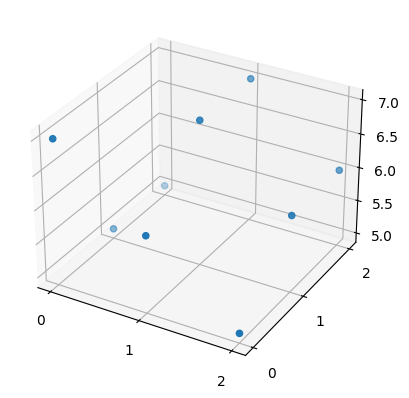

In [42]:
# generating an arbitrary sequence of pairs of numbers (not with missing values)
min = 5
max = 8
length = 3
ax = plt.axes(projection='3d')
x = list(range(length))*length
y = np.array(([[i]*length for i in range(length)])).flatten()
z = np.random.randint(min, max, (length,length))
plt.xticks(np.arange(0, length))
plt.yticks(np.arange(0, length))
ax.scatter3D(x, y, z)
plt.show()

# 참고한 자료들
1. [Jeffrey Chasnov, Cubic Spline Interpolation (youtube)](https://youtu.be/LaolbjAzZvg)
1. [위키피디아](https://wikipedia.org)
1. [Cubic splines better than quadratic splines? (stackoverflow)](https://math.stackexchange.com/questions/1221194/cubic-splines-better-than-quadratic-splines)
1. [Quadratic Spline Interpolation(pennstate)](https://psu.pb.unizin.org/polynomialinterpretation/chapter/chapter-three-quadratic-spline-interpolation/)
1. [Arne Morten Kvarving, Natural cubic splines](https://www.math.ntnu.no/emner/TMA4215/2008h/cubicsplines.pdf)